In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

import torchvision.datasets
import torchvision.transforms as T
import torchvision.models

In [2]:
import sys
if 'trainer' in sys.modules:
    del sys.modules['trainer']
import trainer
from trainer import device

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [4]:
dataset = torchvision.datasets.VOCDetection(".", download=True, image_set="trainval", transforms=lambda x, y: voc_transform(x, y))
dataset_aug = torchvision.datasets.VOCDetection(".", download=True, image_set="trainval", transforms=lambda x, y: voc_transform(x, y, augment=True))
classes = {'__none__':0, 'aeroplane':1, 'bicycle':2, 'bird':3, 'boat':4, 'bottle':5, 'bus':6, 'car':7, 'cat':8, 'chair':9, 'cow':10, 'diningtable':11, 'dog':12, 'horse':13, 'motorbike':14, 'person':15, 'pottedplant':16, 'sheep':17, 'sofa':18, 'train':19, 'tvmonitor':20}

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .
Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [5]:
def voc_transform(x, y, augment=False, grid=13):
    ann = y["annotation"]
    width, height = int(ann["size"]["width"]), int(ann["size"]["height"])

    x = T.functional.to_tensor(x)
    x = T.functional.resize(x, [grid*32, grid*32], antialias=False)
    
    augx, augy, augs, augf = 0, 0, 1, False
    
    if augment:
        rnd = torch.rand((4,))
        augx = rnd[0].item() * 0.6 - 0.3 # +-30% translate
        augy = rnd[1].item() * 0.6 - 0.3
        augs = rnd[2].item() * 0.7 + 0.5 # 0.5 .. 1.2
        augf = rnd[3].item() < 0.1 # 10% change of horizontal flip
        
        x = T.functional.affine(x, 0, [int(augx * x.shape[1]), int(augy * x.shape[2])], augs, 0)
        if augf:
            x = T.functional.hflip(x)

    y = torch.zeros((5, grid, grid))
    for obj in ann["object"]:
        bbox = obj["bndbox"]
        clsid = classes[obj["name"]]
        bx, by, bw, bh = int(bbox["xmin"]) / width, int(bbox["ymin"]) / height, (int(bbox["xmax"]) - int(bbox["xmin"])) / width, (int(bbox["ymax"]) - int(bbox["ymin"])) / height
        
        if augment:
            bx0, bx1, by0, by1 = bx, bx + bw, by, by + bw
            # scale around image center and translate
            bx0 = (bx0 - 0.5) * augs + 0.5 + augx
            bx1 = (bx1 - 0.5) * augs + 0.5 + augx
            by0 = (by0 - 0.5) * augs + 0.5 + augy
            by1 = (by1 - 0.5) * augs + 0.5 + augy
            # flip
            if augf:
                bx0, bx1 = 1 - bx1, 1 - bx0
            # clip
            bx0 = max(bx0, 0)
            by0 = max(by0, 0)
            bx1 = min(bx1, 1)
            by1 = min(by1, 1)
            # reconstruct x/y/w/h; note that w/h may become negative, it will be discarded below
            bx, by, bw, bh = bx0, by0, bx1 - bx0, by1 - by0         
            
        if bw < 0.01 or bh < 0.01:
            continue

        cx, cy = int((bx + bw * 0.5) * grid), int((by + bh * 0.5) * grid)
        y[:, cy, cx] = torch.tensor([clsid, bx, by, bw, bh])

    return x, y

In [6]:
def voc_display(x, y):
    fig, ax = plt.subplots()
    ax.imshow(x.permute(1, 2, 0))
    w, h = x.shape[2], x.shape[1]
    palette = "rgbcmy"
    index = 0
    for cy in range(y.shape[1]):
        for cx in range(y.shape[2]):
            obj = y[:, cy, cx]
            if obj[0] == 0:
                continue
            name = next(n for n,i in classes.items() if i == int(obj[0]))
            bx, by, bw, bh = obj[1:]
            color = palette[index % len(palette)]
            index += 1
            rect = patches.Rectangle((bx * w, (by+bh) * h), bw * w, -bh * h, linewidth=1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            # cell = patches.Rectangle((cx/13*w, (cy+1)/13*h), w/13, -h/13, linewidth=1, edgecolor=color, facecolor='none')
            # ax.add_patch(cell)
            ax.text(bx * w + 4, by * h - 4, name, c=color)
    plt.show()

In [7]:
batch_size = 32
train_cutoff = int(len(dataset) * 0.9)
train_data = D.DataLoader(D.Subset(dataset_aug, range(train_cutoff)), batch_size=batch_size, num_workers=12)
val_data = D.DataLoader(D.Subset(dataset, range(train_cutoff, len(dataset))), batch_size=batch_size, num_workers=4)

In [8]:
# as a backbone, we're going to use VGG feature detector. Larger models could improve the quality. We're standardizing on 416x416 => 13x13 networks though so it has to be 5-deep
vgg = torchvision.models.vgg11(weights="DEFAULT").features
for p in vgg.parameters():
    p.requires_grad=False

In [9]:
class SSD(nn.Module):
    # TODO: replace background class with objectness?
    def __init__(self, backbone, classes=21, grid=13, channels=512):
        super().__init__()
        self.grid = grid
        self.classes = classes

        self.anchors = []
        for scale in [1, 3, 7, 11]:
            for aspect in [1/3, 1/2, 1, 2, 3]:
                if aspect > 1:
                    aw = scale
                    ah = scale / aspect
                else:
                    aw = scale * aspect
                    ah = scale
                       
                self.anchors.append((aw / grid, ah / grid))
        
        self.backbone = backbone    
        self.detect = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, len(self.anchors)*(4+classes), kernel_size=1))
        
        self.register_buffer('gridoffx', torch.arange(grid)/grid)
        self.register_buffer('gridoffy', torch.unsqueeze(torch.arange(grid), dim=1)/grid)

    def forward(self, x):
        # normalize image using VGG mean/std
        x = (x - 0.456) / 0.224

        # detect box candidates
        # TODO: forward a 26x26 layer to detect as well, similar to YOLOv2
        y = self.backbone(x)
        y = self.detect(y)
        
        # transform box xywh to image space
        for aidx, (aw, ah) in enumerate(self.anchors):
            aoff = aidx * (4+self.classes)

            y[:, aoff+0, :, :] = F.sigmoid(y[:, aoff+0, :, :])/self.grid + self.gridoffx
            y[:, aoff+1, :, :] = F.sigmoid(y[:, aoff+1, :, :])/self.grid + self.gridoffy
            y[:, aoff+2, :, :] = torch.exp(y[:, aoff+2, :, :])*aw
            y[:, aoff+3, :, :] = torch.exp(y[:, aoff+3, :, :])*ah

            # we infer center of bbox, so we need to convert it to corner
            y[:, aoff+0, :, :] -= y[:, aoff+2, :, :] * 0.5
            y[:, aoff+1, :, :] -= y[:, aoff+3, :, :] * 0.5

        return y
    
    @torch.no_grad()
    def predict(self, x):
        p = self.forward(x)
        
        # grab log/box for first anchor
        plog = p[:, 4:4+self.classes, :, :]
        pbox = p[:, 0:4, :, :]

        # replace log/box with an anchor if its max probability is higher
        for aidx in range(len(self.anchors)):
            aoff = aidx * (4+self.classes)
            alog = p[:, aoff+4:aoff+4+self.classes, :, :]
            abox = p[:, aoff:aoff+4, :, :]
            
            alog1 = torch.clone(alog)
            alog1[:, 0, :, :] = 0
            plog1 = torch.clone(plog)
            plog1[:, 0, :, :] = 0

            alogmax = torch.amax(alog1, dim=1, keepdim=True) # Bx1xHxW
            plogmax = torch.amax(plog1, dim=1, keepdim=True) # Bx1xHxW
            amask = torch.gt(alogmax, plogmax).int().float()

            plog += (alog - plog) * amask
            pbox += (abox - pbox) * amask

        # predict
        pcat = torch.argmax(plog, dim=1, keepdim=True)
        return torch.cat((pcat, pbox), dim=1)
    
    def loss(self, p, y):
        ycat = y[:, 0, :, :]
        ybox = y[:, 1:, :, :]
        
        # we need to only consider box losses for present gt objects
        ymask = (ycat > 0).float()
        ynum = ymask.sum((1,2))
        
        lbatch = torch.zeros((y.shape[0],), dtype=torch.float, device=y.device)
        lnorm = torch.zeros((y.shape[0],), dtype=torch.float, device=y.device)

        wheps = 1e-3 # slightly bias w/h because our ground truth contains zeroes
        athreshold = 0.3

        for aidx, (aw, ah) in enumerate(self.anchors):
            # only accumulate the loss in cells where iou(gt, anchor) > threshold
            # iou(w1, h1, w2, h2) = (min(w1, w2) * min(h1, h2)) / (w1 * h1 + w2 * h2 - min(w1, w2) * min(h1, h2))
            aiou_i = torch.minimum(ybox[:, 2], torch.tensor(aw)) * torch.minimum(ybox[:, 3], torch.tensor(ah))
            aiou = aiou_i / (ybox[:, 2] * ybox[:, 3] + aw * ah - aiou_i + wheps)
            amask = (aiou > athreshold).float()
            
            aoff = aidx * (4+self.classes)

            plog = p[:, aoff+4:aoff+4+self.classes, :, :]
            pbox = p[:, aoff:aoff+4, :, :]

            # TODO: if we had a separate confidence prediction, we could mask lcat with amask? for now, mask category index to force background prediction...
            lcat = F.cross_entropy(plog, (ycat * amask).long(), reduction='none')

            lboxx = F.smooth_l1_loss(pbox[:, 0], ybox[:, 0], reduction='none')
            lboxy = F.smooth_l1_loss(pbox[:, 1], ybox[:, 1], reduction='none')
            lboxw = F.smooth_l1_loss(torch.log(pbox[:, 2]/aw + wheps), torch.log(ybox[:, 2]/aw + wheps), reduction='none')
            lboxh = F.smooth_l1_loss(torch.log(pbox[:, 3]/ah + wheps), torch.log(ybox[:, 3]/ah + wheps), reduction='none')
            lbox = (lboxx + lboxy + lboxw + lboxh) * ymask * amask
            
            lbatch += lcat.sum((1,2))
            lbatch += lbox.sum((1,2))
            lnorm += (ymask * amask).sum((1,2))
        
        # total loss per batch per dimension needs to be normalized by the number of boxes (per batch) and averaged across batches
        return (lbatch / lnorm.clamp(min=1)).mean()

Train [12.101M params]: 100 epochs took 5173.71 sec, train loss 3.542165, val loss 6.432262


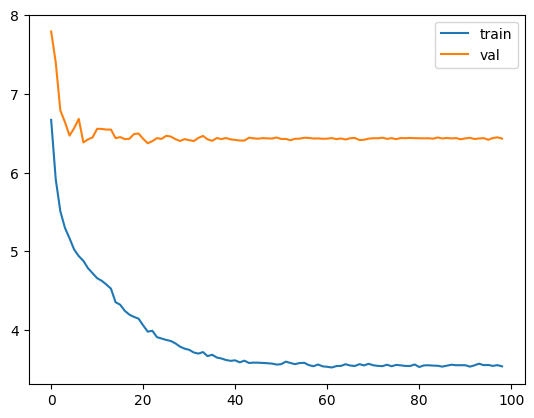

In [10]:
net = SSD(vgg).to(device)
trainer.train(net, train_data, val_data, weight_decay=0.01, epochs=100)
torch.save(net.state_dict(), "objects.pth")

In [11]:
net = SSD(vgg).to(device)
net.load_state_dict(torch.load("objects.pth", weights_only=True))

/home/zeux/.local/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

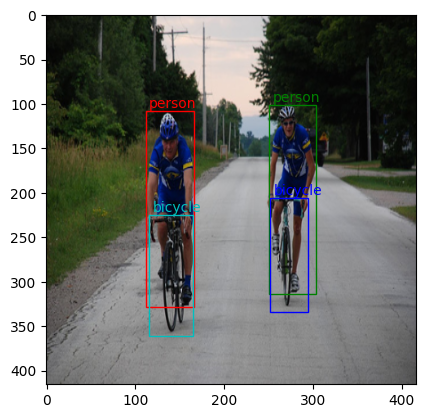

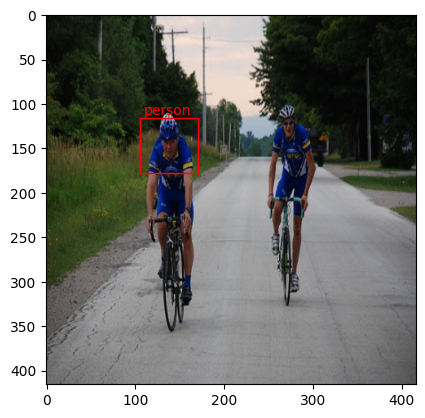

In [13]:
idx = 11079
xex = dataset[idx][0]
pex = net(torch.unsqueeze(xex.to(device), dim=0))
lex = net.loss(pex, torch.unsqueeze(dataset[idx][1].to(device), dim=0))

voc_display(xex, dataset[idx][1])
yex = torch.squeeze(net.predict(torch.unsqueeze(xex.to(device), dim=0)), dim=0).cpu().detach()
voc_display(xex, yex)

In [27]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision

def boxes(y):
    rb, rl = [], []
    for cy in range(y.shape[1]):
        for cx in range(y.shape[2]):
            obj = y[:, cy, cx]
            if obj[0] == 0:
                continue
            rb.append(obj[1:])
            rl.append(obj[0])
    return rb, rl
            
map = MeanAveragePrecision(box_format='xywh')
for idx in range(len(dataset)):
    x = dataset[idx][0]
    y = dataset[idx][1]
    p = torch.squeeze(net.predict(torch.unsqueeze(xex.to(device), dim=0)), dim=0).cpu().detach()
    yb, yl = boxes(y)
    pb, pl = boxes(p)
    map.update(preds=[{'boxes':torch.stack(pb), 'scores':torch.ones(len(pb)), 'labels':torch.stack(pl)}], target=[{'boxes':torch.stack(yb), 'labels':torch.stack(yl)}])
map.compute()

{'map': tensor(6.1826e-08),
 'map_50': tensor(3.2916e-07),
 'map_75': tensor(0.),
 'map_small': tensor(6.1826e-08),
 'map_medium': tensor(-1.),
 'map_large': tensor(-1.),
 'mar_1': tensor(6.2357e-06),
 'mar_10': tensor(6.2357e-06),
 'mar_100': tensor(6.2357e-06),
 'mar_small': tensor(6.2357e-06),
 'mar_medium': tensor(-1.),
 'mar_large': tensor(-1.),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}